In [21]:
%pylab inline
import stanio; from importlib import reload; reload(stanio)
import numpy as np
import pylab as pl
import pandas as pd
import os
import datetime

Populating the interactive namespace from numpy and matplotlib


## Load data

We use processed estimates for Germany here

In [22]:
de_sir_csv = '../data/processed/germany_imperial_college_sir.csv'
de_sir = pd.read_csv(de_sir_csv, parse_dates=['date'])
t0 = datetime.datetime(year=2020, month=2, day=15)
de_rci = de_sir.filter(regex='date|time.*repro.*$')
de_rci.set_index(de_rci.date, inplace=True)
de_rci.set_index((de_rci.index - t0).days, inplace=True)
de_rci

,date,mean_time_varying_reproduction_number_R(t),time_varying_reproduction_number_R(t)_lower_CI_95,time_varying_reproduction_number_R(t)_higher_CI_95
date,,,,
0,2020-02-15,4.317265,3.503551,5.435754
1,2020-02-16,4.317265,3.503551,5.435754
2,2020-02-17,4.317265,3.503551,5.435754
3,2020-02-18,4.317265,3.503551,5.435754
4,2020-02-19,4.317265,3.503551,5.435754
...,...,...,...,...
78,2020-05-03,0.752095,0.646568,0.859221
79,2020-05-04,0.752052,0.646549,0.859133
80,2020-05-05,0.752010,0.646531,0.859047


Looking at reports vs estimates:

(0.001, 100000.0)

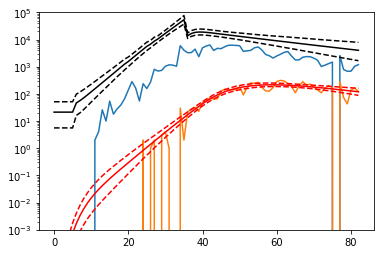

In [23]:
pl.semilogy(de_sir['reported_cases'])
pl.semilogy(de_sir['reported_deaths'])
pl.semilogy(de_sir['predicted_infections_lower_CI_95'], 'k--')
pl.semilogy(de_sir['predicted_infections_higher_CI_95'], 'k--')
pl.semilogy(de_sir['predicted_infections_mean'], 'k')
pl.semilogy(de_sir['estimated_deaths_mean'], 'r')
pl.semilogy(de_sir['estimated_deaths_lower_CI_95'], 'r--')
pl.semilogy(de_sir['estimated_deaths_higher_CI_95'], 'r--')
pl.ylim([1e-3, 1e5])

we see that the estimates follow death reports closest and assume under reporting by at least an order of magnitude.

Next, we assemble a number of reduced datasets, all aligned in time to t=0 at Feb 15th.

In [24]:
#de_pci = de_sir.filter(regex='date|pred.*infec.*cumulative$|reported_cases$|reported_deaths$')
de_pci = de_sir.filter(regex='date|pred.*mean$|pred.*CI_95$|reported_cases$|reported_deaths$')
_, krc, kmu, kqlo, kqhi, krd = de_pci.columns
assert krd == 'reported_deaths'
de_irc = np.r_[de_pci[krc]]
de_ird = np.r_[de_pci[krd]]
de_imu = np.r_[de_pci[kmu]]
de_isd = (np.r_[de_pci[kqhi]] - np.r_[de_pci[kqlo]]) / 4 # 95% is z -1.9 to 1.9

_, kmu, kqlo, kqhi = de_rci.columns
de_idx = np.r_[de_rci.index]
de_rmu = np.r_[de_rci[kmu]]
de_rsd = (np.r_[de_rci[kqhi]] - np.r_[de_rci[kqlo]]) / 4

de_mob_csv = '../data/processed/germany_google_mobility_report.csv'
de_mob = pd.read_csv(de_mob_csv, parse_dates=['date'])
de_mob.set_index(de_mob.date, inplace=True)
de_mob.set_index((de_mob.index - t0).days, inplace=True)
de_mob = de_mob.filter(regex='^retail')
de_mobi = de_mob.index
de_mobp = np.r_[de_mob][:, 0]/100

de_phi_csv = '../data/processed/germany_cosmo_phi.csv'
de_phi = pd.read_csv(de_phi_csv, parse_dates=['date'])
de_phi.set_index(de_phi.date, inplace=True)
de_phi.set_index((de_phi.index - t0).days, inplace=True)
de_iphi = de_phi.index
de_vphi = np.r_[de_phi][:, 1]

Intervention dates are translated to days as follows,

In [25]:
import datetime as dt
ts = [
    dt.datetime(year=2020, month=2, day=15),
    dt.datetime(year=2020, month=3, day=6),
    dt.datetime(year=2020, month=3, day=12),
    dt.datetime(year=2020, month=3, day=14),
    dt.datetime(year=2020, month=3, day=22),
    dt.datetime(year=2020, month=5, day=6)
    ]
t0 = ts[0]
for t in ts:
    print(t, 'is day', (t - t0).days)

2020-02-15 00:00:00 is day 0
2020-03-06 00:00:00 is day 20
2020-03-12 00:00:00 is day 26
2020-03-14 00:00:00 is day 28
2020-03-22 00:00:00 is day 36
2020-05-06 00:00:00 is day 81


These are currently hard codes in the Stan model, but should be easy to pass by data.

Then we plot these data

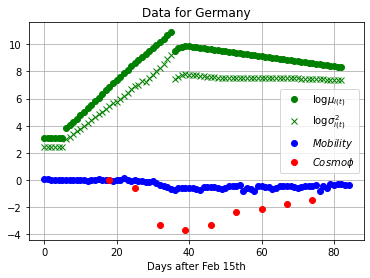

In [26]:
pl.plot(de_idx, np.log(de_imu), 'go')
pl.plot(de_idx, np.log(de_isd), 'gx')
# pl.plot(de_idx, np.log(np.cumsum(de_imu)), 'go')
pl.plot(de_mobi, de_mobp, 'bo')
pl.plot(de_iphi, de_vphi, 'ro')
pl.title("Data for Germany")
pl.xlabel("Days after Feb 15th")
#pl.legend("$\mu_{R0(t)}$ $\sigma^2_{R0(t)}$ $\log{\mu_{I(t)}}$ $\log{\sigma^2_{I(t)}}$ $Mobility$ $Cosmo\phi$".split(' '))
pl.legend("$\log{\mu_{i(t)}}$ $\log{\sigma^2_{i(t)}}$ $Mobility$ $Cosmo\phi$".split(' '))
pl.grid(1)

In [56]:
data = {
    'nii': 20,
    'nr': len(de_idx),
    'rid': de_idx + 1,
    'rmu': de_rmu,
    'rsd': de_rsd,
    # only loosely constrain I with ICL estimates
    'ni': len(de_idx),
    'iid': de_idx + 1,
    'imu': de_imu,
    'isd': de_isd,
    'nc': len(de_idx),
    'cid': de_idx + 1,
    'cases': de_irc.astype('i'),
    'nm': len(de_mobi),
    'mid': np.r_[de_mobi] + 1,
    'mpr': de_mobp,
    'np': len(de_iphi),
    'pid': np.r_[de_iphi] + 1,
    'phi': de_vphi,
    'I0': 1e-6,
    'eps': 1,
    # model comparision params
    'mc_use_pse': 1,
    'mc_use_groups': 1,
    'mc_Gamma_cov': 3.0,
    'mc_ind_Gamma': 0,
    }
init = {
    'gamma': 0.1,
    'Gamma_': np.r_[1.0, 1.0],
    'c': np.r_[0.5,5.0],
    'alpha': 0.1,
    'J': 1.0,
    'ur': -1,
}
stanio.rdump('model.R', data)
stanio.rdump('init.R', init)

In [28]:
cs = '/home/duke/Downloads/cmdstan-2.22.1'
stanio.compile_model(cs, 'model')

In [62]:
init = {
    'gamma': 0.1,
    'Gamma_': np.r_[1.0, 1.0],
    'c_': np.r_[0.5,5.0],
    'alpha': 0.1,
    'J': 0.7,
    'ur': -1
}
stanio.rdump('init.R', init)
!rm -fv fit.csv fit.*.csv
#stanio.bash(f'./model sample init=init.R data file=model.R output refresh=10 file=fit.csv'), f'failed!'
#stanio.diagnose_csvs(cs, 'fit.csv')
!make -C ~/Downloads/cmdstan-2.22.1 $PWD/model
!./model random seed=1337 sample algorithm=hmc engine=nuts max_depth=20 save_warmup=1 init=init.R data file=model.R output file=fit.csv 2>&1 | grep "^Iter"
csv = stanio.parse_csv('fit.csv')

removed 'fit.csv'
make: Entering directory '/home/duke/Downloads/cmdstan-2.22.1'
make: '/home/duke/CovidH_TNG/stan/model' is up to date.
make: Leaving directory '/home/duke/Downloads/cmdstan-2.22.1'
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  100 / 2000 [  5%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  300 / 2000 [ 15%]  (Warmup)
^C


In [58]:
!/home/duke/Downloads/cmdstan-2.22.1/bin/stansummary fit.*.csv | head -n40

Segmentation fault (core dumped)


In [48]:
draws = np.c_[csv['c_'], csv['alpha'], csv['']]

dict_keys(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__', 'c_', 'alpha', 'mpr_a', 'mpr_b', 'phi_a', 'phi_b', 'ur'])

In [38]:
imu = csv['pp_imu']
prc = csv['pp_cases']
pl.figure()
pl.semilogy(de_idx, de_irc)
pl.semilogy(de_idx, de_imu)
pl.semilogy(np.percentile(imu,2.5,axis=0), 'k--')
pl.semilogy(np.percentile(imu,97.5,axis=0), 'k--')
pl.semilogy(np.percentile(imu,2.5,axis=0), 'k--')
pl.semilogy(np.percentile(imu,97.5,axis=0), 'k--')
pl.legend('icl_reports icl_predicted pp2.5% pp97.5%'.split(' '))
pl.title('Daily new infections')

KeyError: 'pp_imu'

In [ ]:
# pl.savefig('debug.png',dpi=100)
# pl.close('all')

# pl.figure()
# pl.plot(csv['gamma'], csv['alpha'], 'k.')
# pl.show()
    

# import datetime as dt
# ts = [
#     dt.datetime(year=2020, month=2, day=15),
#     dt.datetime(year=2020, month=3, day=6),
#     dt.datetime(year=2020, month=3, day=12),
#     dt.datetime(year=2020, month=3, day=14),
#     dt.datetime(year=2020, month=3, day=22),
#     dt.datetime(year=2020, month=5, day=6)
#     ]
# t0 = ts[0]
# for t in ts:
#     print(t, 'is day', (t - t0).days)